# The Runaround - Lab - **Answers**

In this assignment we take on random exploration, as a classic battle of brownian versus levy.

There are two goals. First to introduce these random walks, and to compare their properties. Second to contrast them, in the same search environments. 

## Install and import needed modules

In [ ]:
# Install explorationlib?
# !pip install --upgrade git+https://github.com/parenthetical-e/explorationlib

In [1]:
# Import misc
import shutil
import glob
import os
import copy
import sys

# Vis - 1
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Exp
from explorationlib.run import experiment
from explorationlib.util import select_exp
from explorationlib.util import load
from explorationlib.util import save

# Agents
from explorationlib.agent import Diffusion2d
from explorationlib.agent import Levy2d
from explorationlib.agent import TruncatedLevy2d

# Env
from explorationlib.local_gym import Field
from explorationlib.local_gym import Bounded
from explorationlib.local_gym import Grid 
from explorationlib.local_gym import uniform_targets
from explorationlib.local_gym import constant_values

# Vis - 2
from explorationlib.plot import plot_position2d
from explorationlib.plot import plot_length_hist
from explorationlib.plot import plot_length
from explorationlib.plot import plot_targets2d
from explorationlib.plot import show_gif

# Score
from explorationlib.score import search_efficiency
from explorationlib.score import average_reward
from explorationlib.score import first_reward

pygame 2.0.1 (SDL 2.0.14, Python 3.6.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# A home for data
if not os.path.exists("data"):
    os.makedirs("data")

# Shared naming
base_name = "data/lab1"

In [3]:
# Pretty plots
%matplotlib inline
%config InlineBackend.figure_format='retina'
%config IPCompleter.greedy=True

plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["font.size"] = "16"

# Dev
# Uncomment for local development
%load_ext autoreload
%autoreload 2

## Section 1 - getting to know our explorers

Run a diffusion and levy walker for 10000 steps, in an unbounded Field. Do 10 different experiments.

In [4]:
# Setup
num_steps = 10000
num_experiments = 10
detection_radius = 1

min_length = 0.1
step_size = 0.1  # Should be < (2 * detection_radius)

# Cleanup 
for path in glob.glob(f"{base_name}_*.pkl"):
    os.remove(path)
    
# Create env 
env = Field()

# Create agents
diffusion = Diffusion2d(
    min_length=min_length, 
    scale=0.1, 
    detection_radius=detection_radius, 
    step_size=step_size,
)
levy = Levy2d(min_length=min_length, 
    exponent=2, 
    detection_radius=detection_radius, 
    step_size=step_size,
)

# !
levy_exp = experiment(f"{base_name}_levy_1.pkl", 
    levy, 
    env, 
    num_steps=num_steps, 
    num_experiments=num_experiments,
    seed=59393,
    dump=False,
)
diffusion_exp = experiment(f"{base_name}_diffusion_1.pkl", 
    diffusion, 
    env, 
    num_steps=num_steps, 
    num_experiments=num_experiments,
    seed=59393,
    dump=False,
)

lab1_diffusion_1: 100%|██████████| 10/10 [00:04<00:00,  2.40it/s]


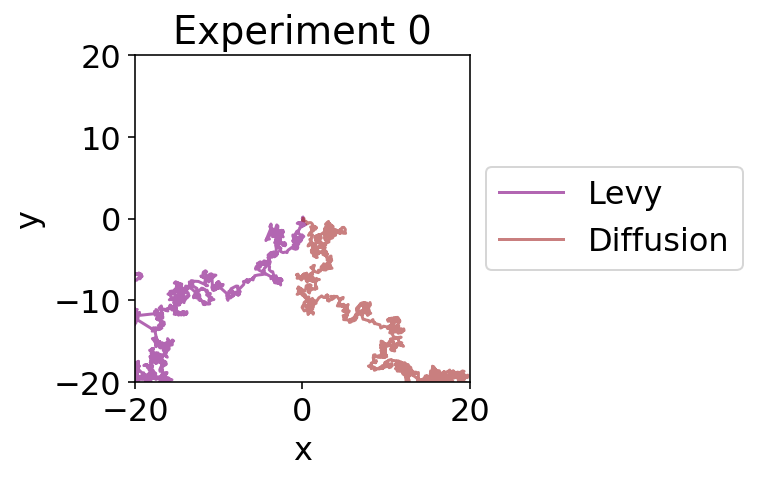

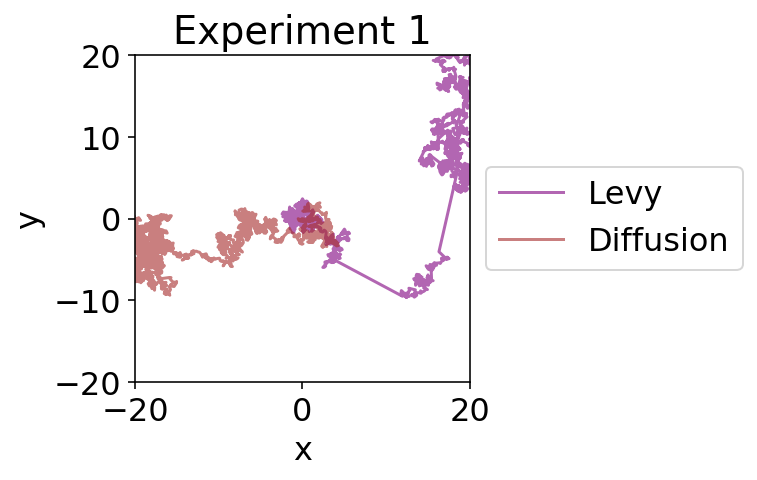

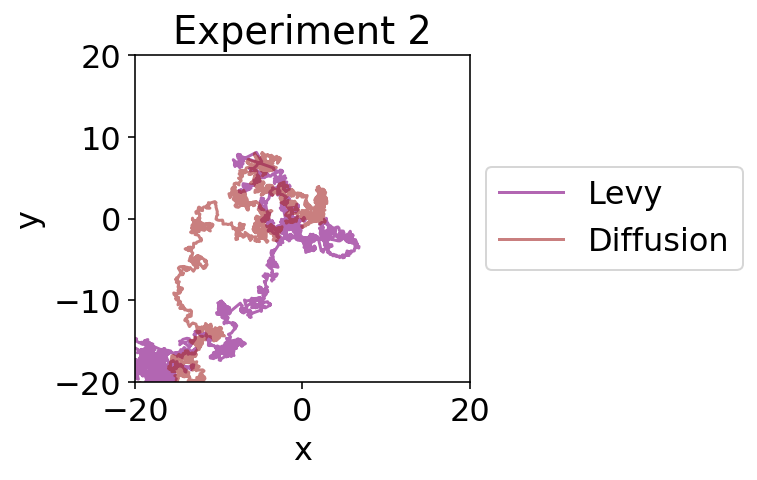

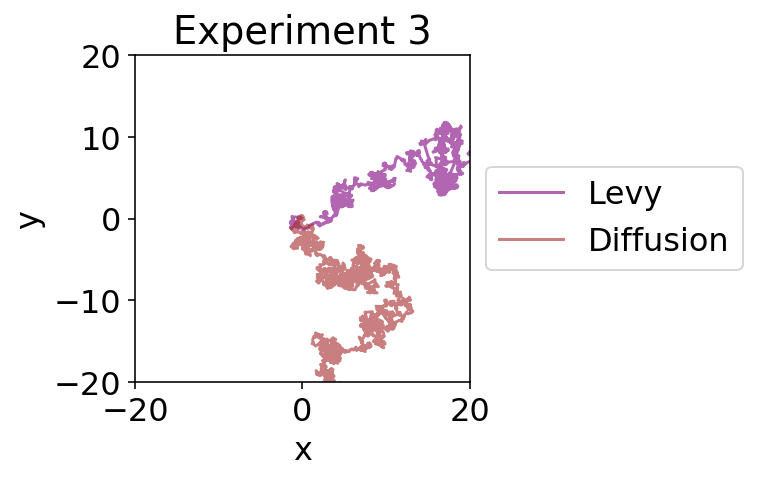

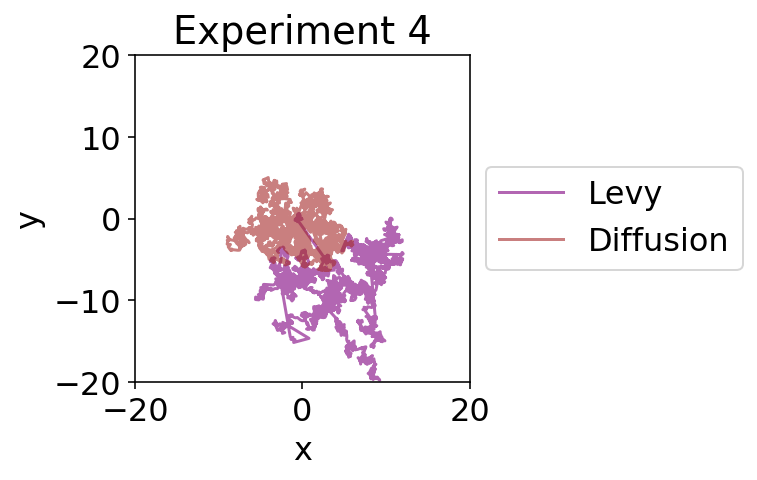

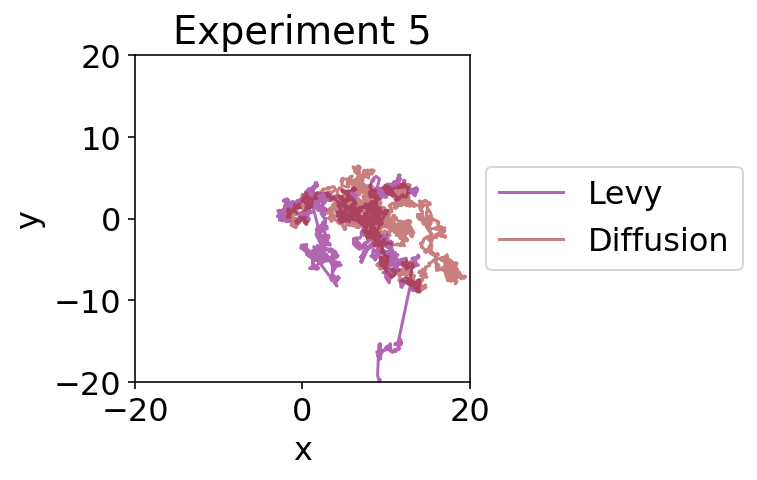

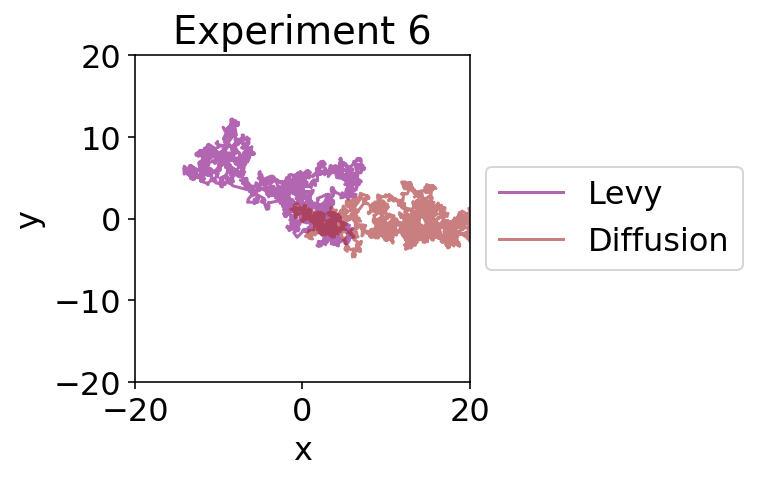

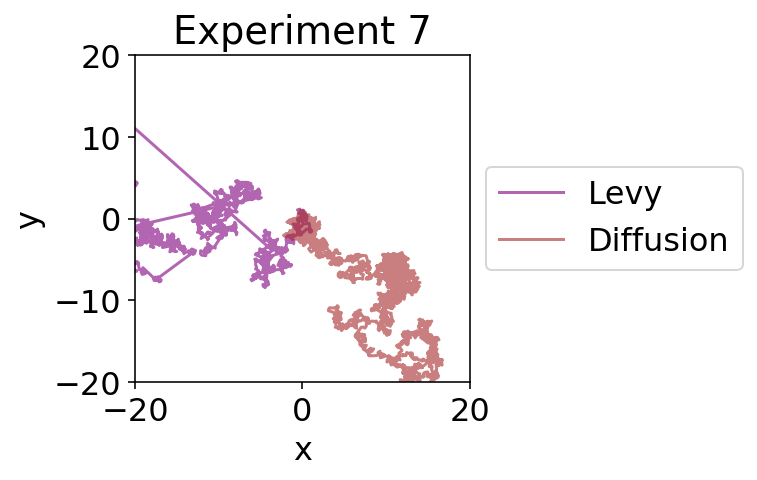

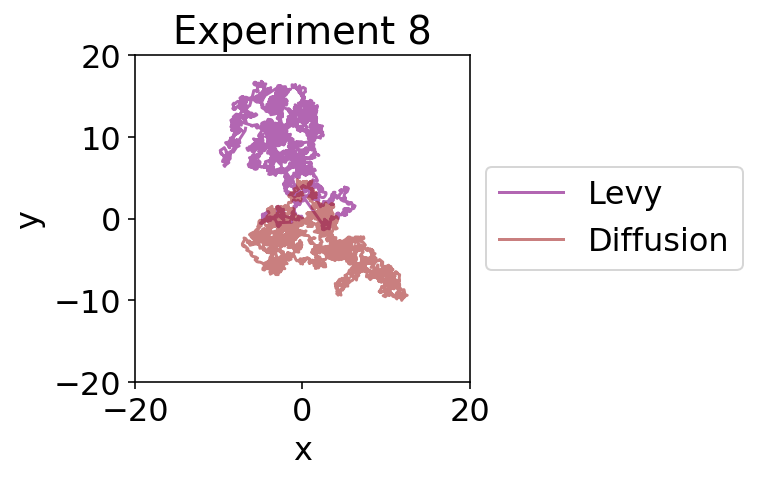

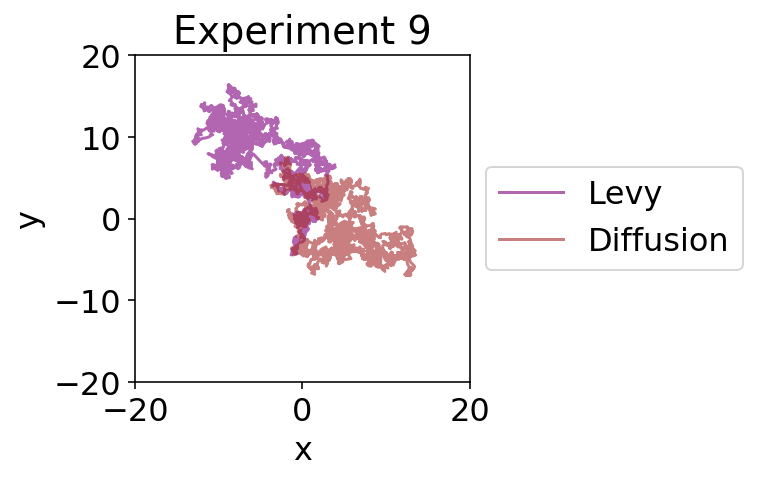

In [5]:
# View size
plot_boundary = (20, 20)

# Generate 10 plots of walking
for n in range(num_experiments):
    ax = None
    ax = plot_position2d(
        select_exp(levy_exp, n),
        boundary=plot_boundary,
        label=f"Levy",
        color="purple",
        alpha=0.6,
        ax=ax,
    )
    ax = plot_position2d(
        select_exp(diffusion_exp, n),
        boundary=plot_boundary,
        label=f"Diffusion",
        title=f"Experiment {n}",
        color="brown",
        alpha=0.6,
        ax=ax,
    )

### Question 1.1
Based on these 10 example experiments please describe how similar or different the Levy and diffusion search strategies seem to be? Visually, that is. Can you tell the difference between them in _all_ 10 examples?

_Note_: Don't be afraid to change the _plot boundary_ to zoom in or out. 

In [ ]:
# STUDENT: Five or six of exmaples do seem to be remarkably similiar. THe difference in the others, qualitativily, is the long jumps. These are Levy's most salient feature, of course. 

# COMMENTARY: The stochastic nature of the method means this most salient feature does not always appear in individual trials or bour of exploration. Is this ideal? (PS Gelmam versus population trials, come to mind.) 
#
# Intermitent search w/ TruncatedLevy would be more robust for single bouts? How different would it look at the population level
#
# I showed you this because the examples in the papers and tectbooks are too perfect or cannonical. That is itself misleading.

Create one distribution for all Levy walks, and one distribution and plot them together. First plot the distributions, the plot them in log-log space. AKA the space in which power laws, like the Levy $p(l) = 1 / l^{\mu}$, are easiest to identify. 

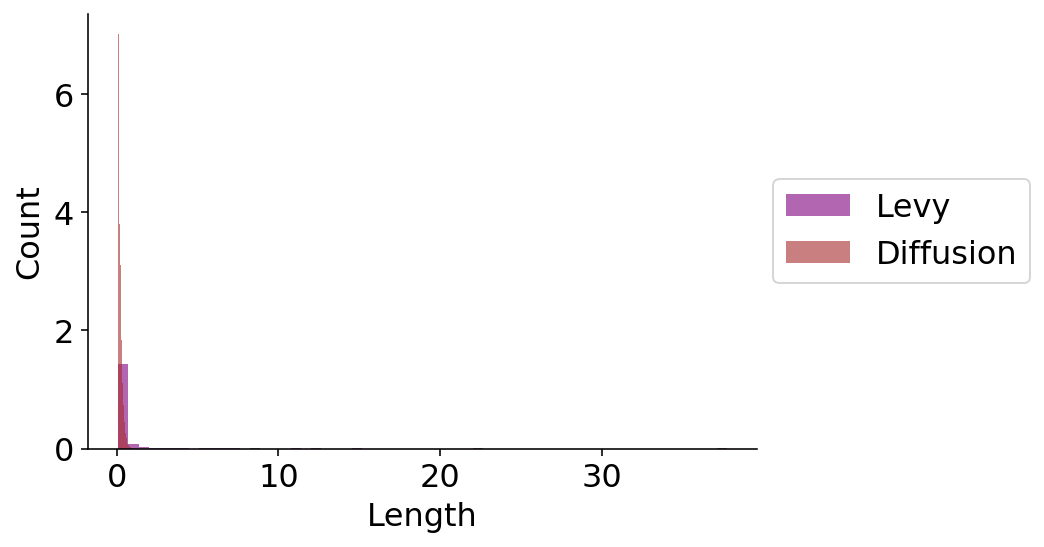

In [6]:
ax = None
ax = plot_length_hist(
    levy_exp,
    loglog=False,
    bins=60,
    density=True,
    alpha=0.6,
    label="Levy",
    color="purple",
    ax=ax,
    figsize=(6,4),
)
ax = plot_length_hist(
    diffusion_exp,
    loglog=False,
    bins=50,
    density=True,
    alpha=0.6,
    color="brown",
    label="Diffusion",
    ax=ax,
)
sns.despine() # Make pretty plot

- Wow, the power law is steep right!? Can you see the exponential nature of diffusion?

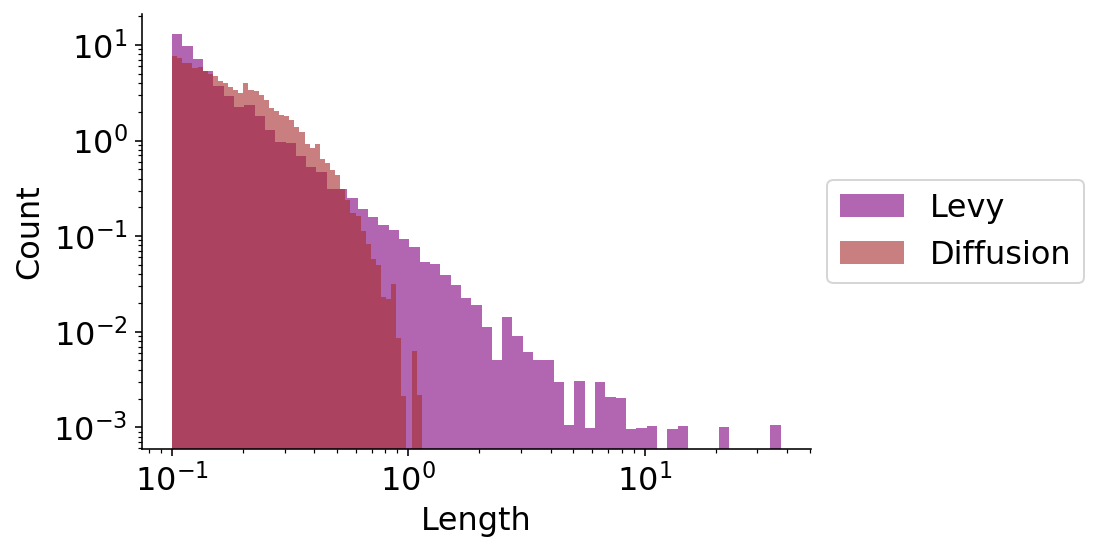

In [7]:
ax = None
ax = plot_length_hist(
    levy_exp,
    loglog=True,
    bins=60,
    density=True,
    alpha=0.6,
    label="Levy",
    color="purple",
    ax=ax,
    figsize=(6, 4),
)
ax = plot_length_hist(
    diffusion_exp,
    loglog=True,
    bins=50,
    density=True,
    alpha=0.6,
    color="brown",
    label="Diffusion",
    ax=ax,
)
sns.despine() # Make pretty plot

### Question 1.2

In

> Viswanathan, G. M. et al. Optimizing the success of random searches. Nature 401, 911–914 (1999).

the authors made two big claims only one of which I have paid attention too. Levy flight optimality, that is. The _other claim_ is that for dense targets the optimal search strategy is _not_ Levy, but is simple diffusion (AKA brownian motion).

_Reminder_: The claim of Levy optimality holds only when the detection radius $r_v$ is much less than the average distance between targets $\bar d$. That is, when $r_v << \bar d$. Let's call this a sparse setting. This means that as $r_v$ approaches $\bar d$, the problem becomes what we can call dense. Sparse and dense refer to the targets, of course.

These distributions are huge hints to why Levy and diffusion are optimal, respectively, in dense and sparse settings. Can you explain why? 

_Hint_: Reflect on the distribution of lengths. Consider where the most "mass" is in each distribution. Then reflect on the two settings. Maybe make plots of each setting to help you?

In [ ]:
# STUDENT: For the sense setting there is no reason to travel ery far from where you start, and Diffusion favors this. A Levy jump is just wasted effort.
#
# For the sparse setting, begining aat any one point means a target beign nerarby is not likely. You need to be able to jump around to change into one, the hand around to harvet it. 
#
# These distributions show the two methods have these respective properties.

# COMMENTARY: Why only these two? Why do they show up most often? Some larger principle at play?

### Question 1.3
I have already claimed the ratio $r_v/\bar{d}$ is a reasonable way to measure the difficulty of a random search problem. Where, that is, $r_v$ is the detection radius of the explorer and $\bar d$ is the average distance between targets. 

In theory we can change this ratio by changing $r_v$ directly or manipulate $d$ by changing the total number of targets $N$, or the size of the domain $L$. For randomly placed targets, anyway. In practice, as in the examples below, we change only $r_v$ or $N$. Can you guess the practical reason for this? Why hold $L$ fixed? (AKA the `boundary`.)

In [ ]:
# STUDENT: ...run time.
# STUDENT: Agents can't change the size of their worlds, but nor can they change real N.

### Question 1.4
Can you come up with a counter example where the ratio $r_v/\bar{d}$ could be misleading, incomplete, or both?

_Hint_: Try drawing out different arrangements of targets and search domains?

In [ ]:
# STUDENT: ...patches or any other ansiotropic target layout. 
# 
# COMMENTARY: We need a neighbrhood notion? This would cover all cases but is hard to scalarize?

### Question 1.5

I have claimed the ratio $N_t / \bar l$ is a reasonable way to measure how global or local a search is. Where, that is, $N_t$ number of turns and $\bar l $ is the average length travel. 

Examine the plot below, in light of this claim. How global or local are levy and diffusion searches in comparison to each other? 

_Hint_: For a hint on the turn number count question, look at the distributions from the previous section. 


In [ ]:
ax = None
ax = plot_length(
    select_exp(levy_exp, 0),
    label="Levy",
    color="purple",
    alpha=0.7,
    figsize=(8, 3),
    ax=ax,
)
ax = plot_length(
    select_exp(diffusion_exp, 0),
    label="Diffusion",
    color="brown",
    alpha=0.7,
    ax=ax,
)

In [ ]:
# STUDENT: for the same turn number, we go farther with Levy. (_This is the same as the distribution question silly instructor!_)

# COMMENTAARY: I had you look at the same phenomenon three ways - examples, highs, by turn. Am I silly or was there a point.

## Section 2 - a competition in exploration

As a demo for the questions to come, run our two explorerers on the same environment, 100 times.

In [1]:
# Experiment settings
num_experiments = 100
num_steps = 50000
num_targets = 500
step_size = 0.05
detection_radius = 0.1

# Speed up the search; use TruncatedLevy2d
min_length = 0.05

# Env
env = Field()

# Targets
target_boundary = (50, 50)
targets = uniform_targets(num_targets, target_boundary)
values = constant_values(targets, 1)
env.add_targets(targets, values, detection_radius=detection_radius)

# Agents
brown = Diffusion2d(min_length=min_length,
                          scale=.1,
                          detection_radius=detection_radius, step_size=step_size)
levy2 = Levy2d(min_length=min_length,
                              exponent=2,
                              detection_radius=detection_radius, step_size=step_size)

# Cleanup 
for path in glob.glob(f"{base_name}_*.pkl"):
    os.remove(path)

# !
levy_exp = experiment(
    f"{base_name}_levy_2.pkl", 
    levy2,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
)
diffusion_exp = experiment(
    f"{base_name}_diffusion_2.pkl", 
    brown,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
)

NameError: name 'Field' is not defined

Plot an experiment, if you want. 

In [ ]:
num_experiment = 1  # Which exp to plot?
plot_boundary = (50, 50) # View size

ax = plot_position2d(
    select_exp(levy_exp, num_experiment),
    boundary=plot_boundary,
    label="Levy",
    color="purple",
    alpha=0.6,
    figsize=(3, 3),
)
ax = plot_position2d(
    select_exp(diffusion_exp, num_experiment),
    boundary=plot_boundary,
    label="Brownian",
    color="brown",
    alpha=0.6,
    ax=ax,
)
ax = plot_targets2d(
    env,
    boundary=plot_boundary,
    color="black",
    alpha=1,
    label="Targets",
    ax=ax,
)

In [ ]:
ax = None
ax = plot_length_hist(
    select_exp(levy_exp, num_experiment),
    loglog=True,
    bins=60,
    density=True,
    alpha=0.6,
    label="Levy",
    color="purple",
    ax=ax,
    figsize=(6, 4),
)
ax = plot_length_hist(
    select_exp(diffusion_exp, num_experiment),
    loglog=True,
    bins=50,
    density=True,
    alpha=0.6,
    color="brown",
    label="Diffusion",
    ax=ax,
)
sns.despine() # Make pretty plot

Get efficiciecy for all experiments

In [ ]:
# Results, names, and colors
results = [levy_exp, diffusion_exp]
names = ["Levy", "Diffusion"]
colors = ["purple", "brown"]

# Score by eff
scores = []
for name, res, color in zip(names, results, colors):
    r = search_efficiency(res)
    scores.append(r)   

Plot distributions

In [ ]:
for (name, s, c) in zip(names, scores, colors):
    plt.hist(s, label=name, color=c, alpha=0.5, bins=20)
    plt.legend()
    plt.xlabel("Score")
    plt.tight_layout()
    sns.despine()

Plot averages

In [ ]:
# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot
fig = plt.figure(figsize=(3, 3))
plt.bar(names, m, yerr=sd, color="black", alpha=0.6)
plt.ylabel("Score")
plt.tight_layout()
sns.despine()

### Question 2.1
Vary the _detection radius_ parameter (what I have been calling $r_v$) beginning with 2.0 and ending around 0.25, in 5 or so increments. For each increment, make a histogram of the search efficiencies for both Levy and diffusion search. The code above will help you get started.

Before you write the code, first write out what you expect to happen as $r_v$ decreases. Your hypothesis based on what you have been told so far.

For each increment which method has higher efficiency, and how much do the two distributions seem to overlap?

_Warning:_ This may take a while to run. 

In [ ]:
# STUDENT - the levy search should come to dominate

In [ ]:
# Write your code here

In [ ]:
# STUDENT - brownian is always better?

### Bonus question:
Repeat the first question in the section again, this time varying the _num targets_ instead. Try halving the number. Then doubling it. Are the results very different from when you varied the _detection radius_?

In [ ]:
# Write your code here

In [ ]:
# STUDENT - nothing changes. 
# COMMENTARY - this lab was a disappointment for me as well.